In [1]:
import igraph as ig
from typing import Dict, List
import matplotlib.pyplot as plt
import overpy

In [2]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [3]:
from scripts.config import Config

In [4]:
def eval_way(way, config: Config = Config()):
    score = 0
    max_score = config.weight_sum()
    for tag, value in way.tags.items():
        weight, mapping = config[tag]
        score += weight * mapping.get(value, 0)
    return score / max_score

In [5]:
def filter_ways(result, threshold):
    ways = []
    for way in result.ways:
        score = eval_way(way)
        if score > threshold:
            ways.append(way)
    return ways

In [6]:
def ways_to_edges(ways: List[overpy.Way]):
    link_counter: Dict[str, int] = {}
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        for node in nodes:
            link_counter[node.id] = link_counter.get(node.id, 0) + 1

    edges = []
    all_nodes = set()
    for way in ways:
        nodes = way.get_nodes(resolve_missing=True)
        if len(nodes) == 2:
            edges.append([nodes[0].id, nodes[1].id])  # add way as an edge
            all_nodes.add(nodes[0])
            all_nodes.add(nodes[1])
            continue
        head = nodes[0]
        tail = nodes[len(nodes) - 1]
        prev = head
        for i in range(1, len(nodes) - 1):
            node = nodes[i]
            if link_counter[node.id] > 1:
                # break the way on node
                edges.append([prev.id, node.id])
                all_nodes.add(prev)
                all_nodes.add(node)
                prev = node
                if i == len(nodes) - 2:
                    edges.append([node.id, tail.id])
                    all_nodes.add(tail)
    return edges, list(all_nodes)

In [7]:
api = overpy.Overpass()
# result = api.query("nwr(56.3284, -2.8350, 56.3437, -2.7855); out;")  # st andrews
result = api.query("nwr(56.3375, -2.8059, 56.3422, -2.7888); out;")

In [8]:
# tag_count = {}
# for way in result.ways:
#     for tag in way.tags:
#         tag_count[tag] = tag_count.get(tag, 0) + 1
# dict(sorted(tag_count.items(), key=lambda item: item[1]))

In [9]:
# highway_count = {}
# for way in result.ways:
#     for tag, value in way.tags.items():
#         if tag == 'highway':
#             highway_count[value] = highway_count.get(value, 0) + 1
# dict(sorted(highway_count.items(), key=lambda item: item[1]))

In [10]:
ways = filter_ways(result, 0)

In [11]:
edges, all_nodes = ways_to_edges(ways)
node_mapping = {node.id: idx for idx, node in enumerate(all_nodes)}
mapped_edges = [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in edges]

In [12]:
print(len(edges))
print(len(all_nodes))

330
339


In [13]:
layout = [(float(node.lon), float(node.lat)) for node in all_nodes]

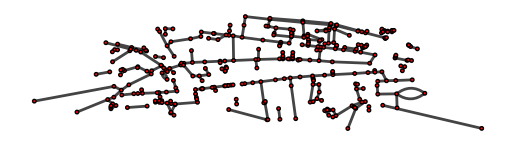

In [14]:
g = ig.Graph(n=len(all_nodes), edges=mapped_edges)
fig, ax = plt.subplots()
ig.plot(g, target=ax, layout=layout, vertex_size=0.0002, bbox=(800,400))
plt.show()

In [15]:
components = g.connected_components()
components.summary()

'Clustering with 339 elements and 27 clusters'

In [16]:
histogram = components.size_histogram(bin_width=10)
print(histogram)

N = 27, mean +- sd: 12.5556 +- 28.1771
[  0,  10): ******************** (20)
[ 10,  20): **** (4)
[ 20,  30): * (1)
[ 30,  40): * (1)
[ 40,  50):  (0)
[ 50,  60):  (0)
[ 60,  70):  (0)
[ 70,  80):  (0)
[ 80,  90):  (0)
[ 90, 100):  (0)
[100, 110):  (0)
[110, 120):  (0)
[120, 130):  (0)
[130, 140):  (0)
[140, 150): * (1)


In [17]:
sorted_components = sorted(list(enumerate(components)), key=lambda x: len(x[1]), reverse=True)

In [18]:
# size of the largest component
len(sorted_components[0][1])

148

In [19]:
# index of largest and second largest components
max_indices = [sorted_components[0][0], sorted_components[1][0]]
max_indices

[1, 3]

In [20]:
# proportion of nodes covered by the largest component
len(sorted_components[0][1]) / len(all_nodes)

0.4365781710914454

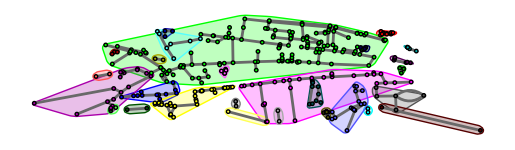

In [21]:
fig, ax = plt.subplots()
ig.plot(components, target=ax, layout=layout, vertex_size=0.0002, bbox=(800,400), mark_groups=True)
plt.show()

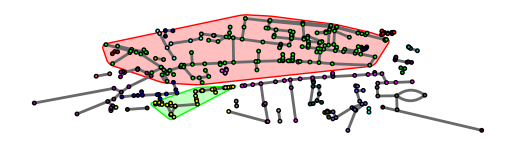

In [22]:
fig, ax = plt.subplots()
ig.plot(components, target=ax, layout=layout, vertex_size=0.0002, bbox=(800,400), mark_groups=max_indices)
plt.show()